# ⚡ 10e - Fast Multi-Output Forecast (SHAP Features, Optimized)

This notebook forecasts only SHAP-relevant features using faster settings:
- Uses **last 2 years of data** for training
- Sets `n_estimators=20` and `n_jobs=-1` for speed
- **Resamples Oil Price to daily frequency**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 📦 Load Data and Filter for Last 2 Years (2018–2019)

In [2]:
df = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])
df.set_index('utc_timestamp', inplace=True)
df = df.sort_index()

# Focus on last 2 years for speed
df = df[df.index >= '2018-01-01']

# Ratio features
df['solar_load_ratio'] = df['DE_solar_generation_actual'] / df['DE_load_actual_entsoe_transparency']
df['wind_load_ratio'] = df['DE_wind_generation_actual'] / df['DE_load_actual_entsoe_transparency']

# Resample oil price to daily then upsample back with ffill
df['Oil_Price'] = df['Oil_Price'].resample('D').mean().reindex(df.index).fillna(method='ffill')

C:\Users\iTECH\AppData\Local\Temp\ipykernel_14288\670254806.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Oil_Price'] = df['Oil_Price'].resample('D').mean().reindex(df.index).fillna(method='ffill')


## 🔮 Forecast Each SHAP-Selected Feature (Optimized Training)

⚡ Forecasting: DE_solar_generation_actual


C:\Users\iTECH\AppData\Local\Temp\ipykernel_14288\1035487580.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_idx = pd.date_range(start='2019-12-25 00:00:00', periods=forecast_horizon, freq='H')


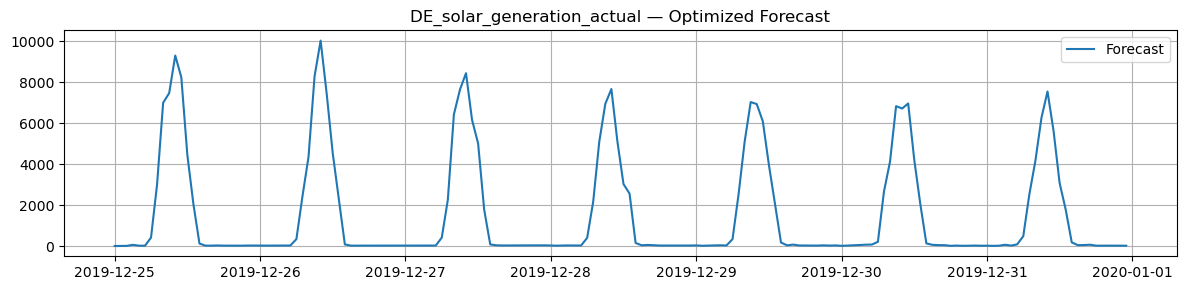

⚡ Forecasting: DE_wind_generation_actual


C:\Users\iTECH\AppData\Local\Temp\ipykernel_14288\1035487580.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_idx = pd.date_range(start='2019-12-25 00:00:00', periods=forecast_horizon, freq='H')


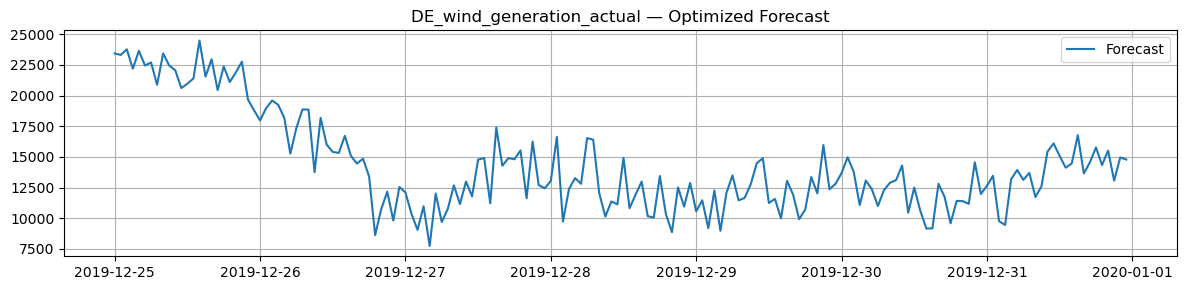

⚡ Forecasting: DE_load_actual_entsoe_transparency


C:\Users\iTECH\AppData\Local\Temp\ipykernel_14288\1035487580.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_idx = pd.date_range(start='2019-12-25 00:00:00', periods=forecast_horizon, freq='H')


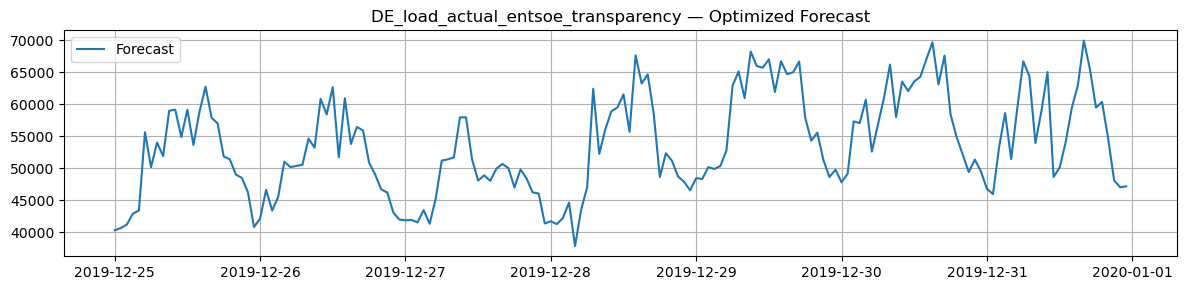

⚡ Forecasting: Oil_Price


C:\Users\iTECH\AppData\Local\Temp\ipykernel_14288\1035487580.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_idx = pd.date_range(start='2019-12-25 00:00:00', periods=forecast_horizon, freq='H')


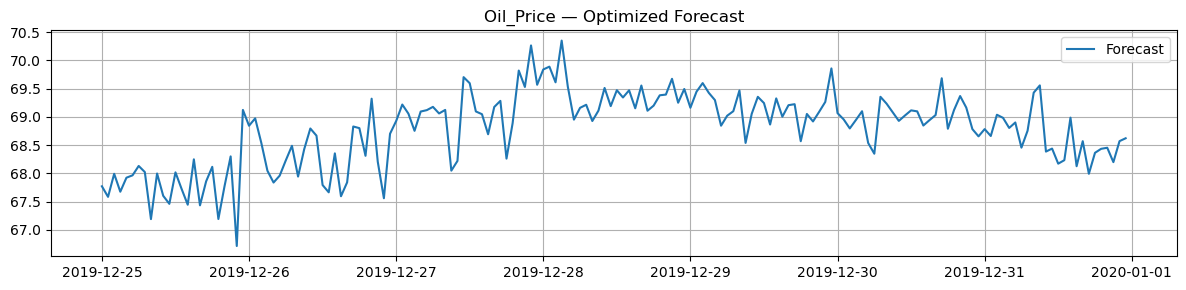

⚡ Forecasting: wind_load_ratio


C:\Users\iTECH\AppData\Local\Temp\ipykernel_14288\1035487580.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_idx = pd.date_range(start='2019-12-25 00:00:00', periods=forecast_horizon, freq='H')


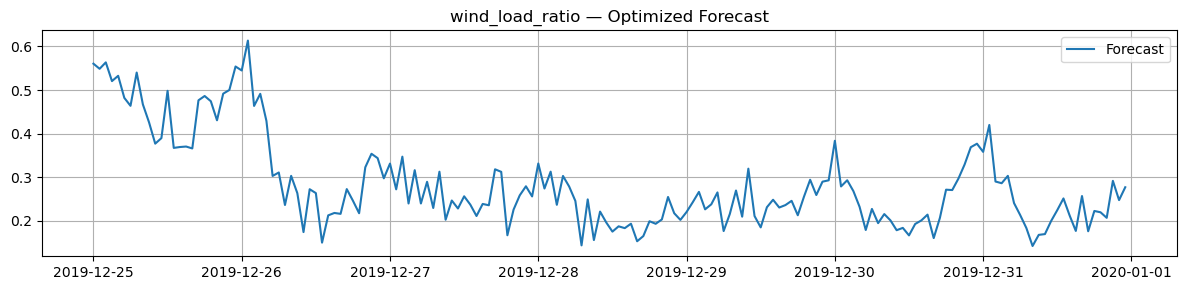

⚡ Forecasting: solar_load_ratio


C:\Users\iTECH\AppData\Local\Temp\ipykernel_14288\1035487580.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_idx = pd.date_range(start='2019-12-25 00:00:00', periods=forecast_horizon, freq='H')


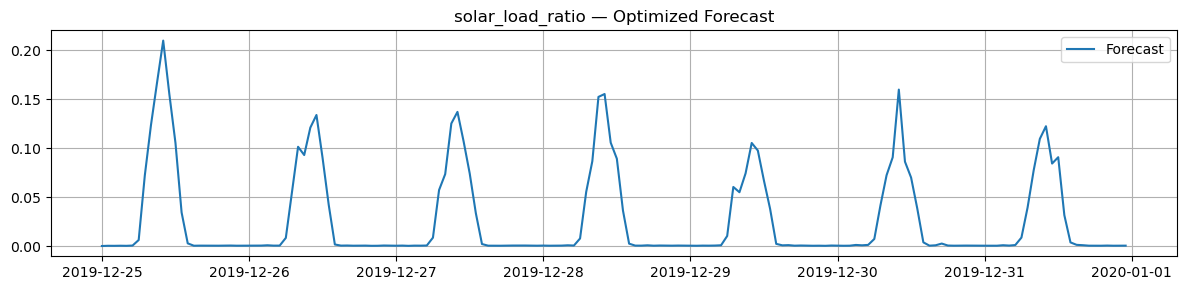

✅ Forecast saved to processed folder.


In [3]:
forecast_horizon = 168  # 1 week
input_lag = 168

targets = [
    'DE_solar_generation_actual', 'DE_wind_generation_actual',
    'DE_load_actual_entsoe_transparency', 'Oil_Price',
    'wind_load_ratio', 'solar_load_ratio'
]

all_forecasts = {}

for feature in targets:
    print(f'⚡ Forecasting: {feature}')
    series = df[feature].dropna()
    X, Y = [], []

    for i in range(input_lag, len(series) - forecast_horizon):
        X.append(series.iloc[i - input_lag:i].values)
        Y.append(series.iloc[i:i + forecast_horizon].values)

    X = np.array(X)
    Y = np.array(Y)

    model = MultiOutputRegressor(XGBRegressor(n_estimators=20, n_jobs=-1))
    model.fit(X, Y)

    last_input = series.iloc[-input_lag:].values.reshape(1, -1)
    forecast = model.predict(last_input)[0]
    forecast_idx = pd.date_range(start='2019-12-25 00:00:00', periods=forecast_horizon, freq='H')

    forecast_df = pd.DataFrame({feature: forecast}, index=forecast_idx)
    all_forecasts[feature] = forecast_df

    plt.figure(figsize=(12, 3))
    plt.plot(forecast_df.index, forecast_df[feature], label='Forecast')
    plt.title(f'{feature} — Optimized Forecast')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Save
df_forecast_all = pd.concat(all_forecasts.values(), axis=1)
df_forecast_all.to_csv('../data/processed/multioutput_forecast_shap_features_fast.csv')
print('✅ Forecast saved to processed folder.')

Evaluating results

DE_solar_generation_actual → MAE: 929.34, RMSE: 1909.02


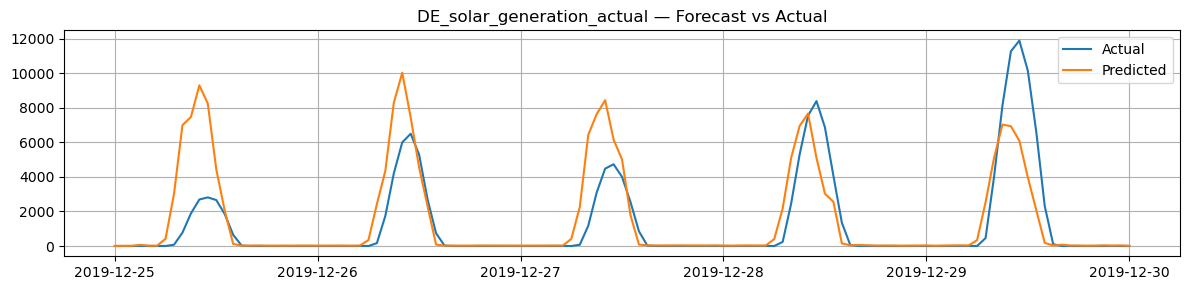

DE_wind_generation_actual → MAE: 7123.43, RMSE: 8041.65


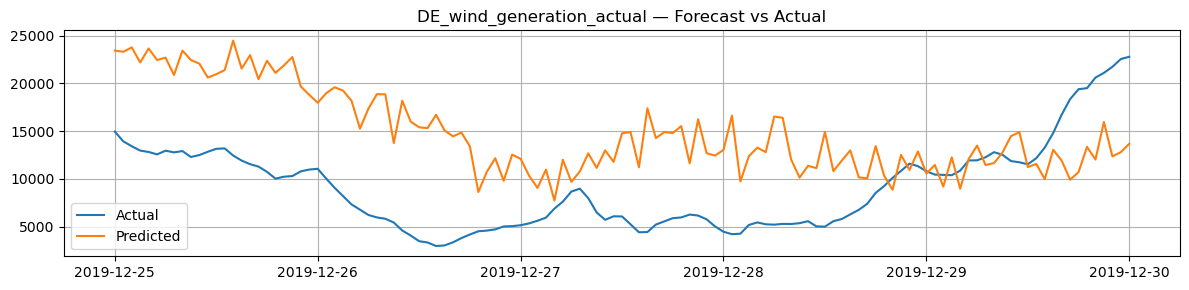

DE_load_actual_entsoe_transparency → MAE: 7500.05, RMSE: 9281.84


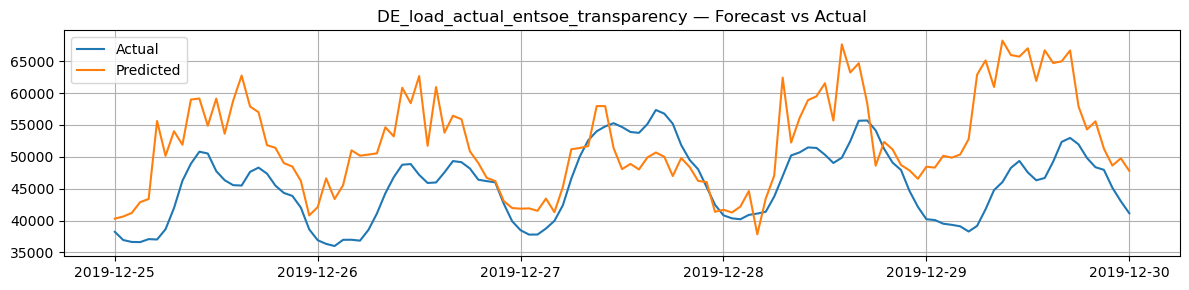

Oil_Price → MAE: 0.73, RMSE: 0.92


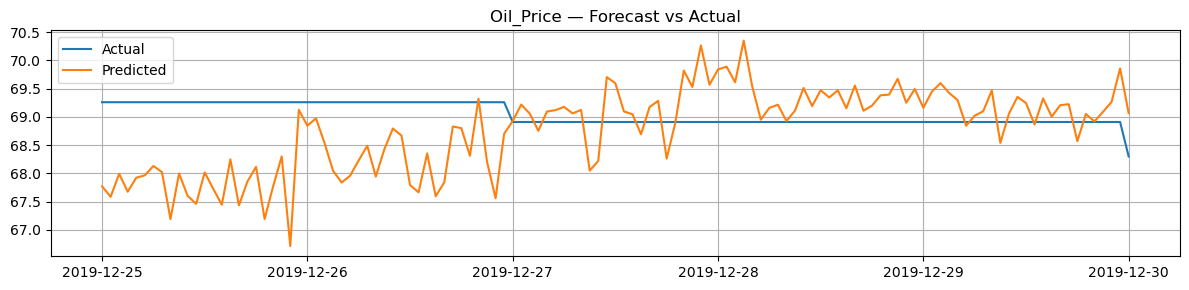

wind_load_ratio → MAE: 0.13, RMSE: 0.15


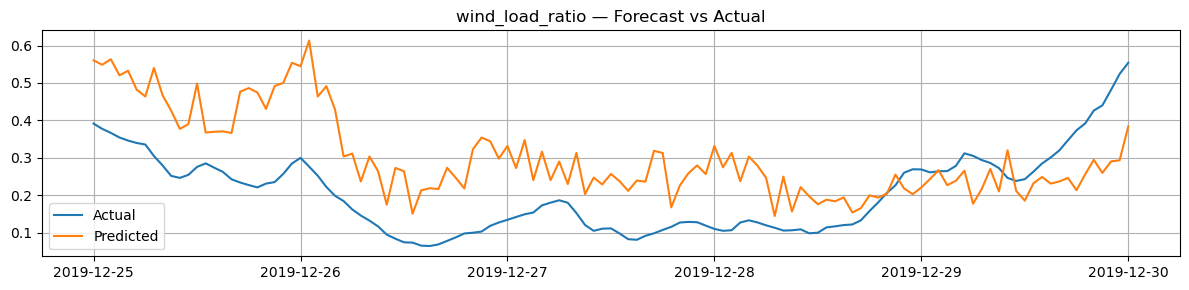

solar_load_ratio → MAE: 0.02, RMSE: 0.04


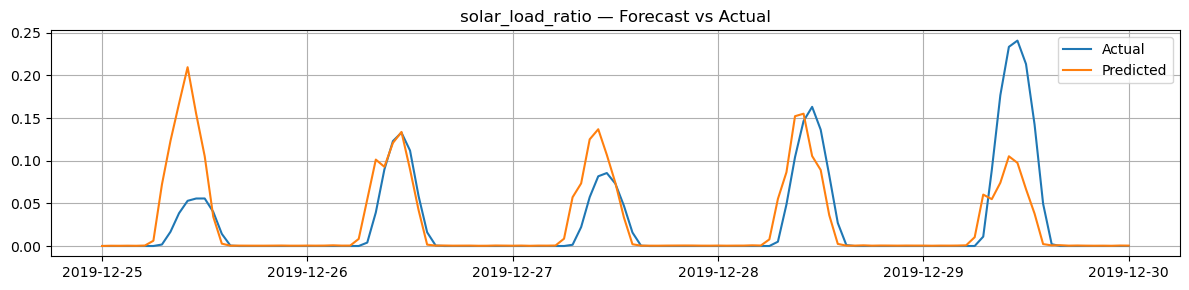

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load actual data
df_actual = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])
df_actual.set_index('utc_timestamp', inplace=True)
# Recompute the ratio features in the actual dataset
df_actual['solar_load_ratio'] = df_actual['DE_solar_generation_actual'] / df_actual['DE_load_actual_entsoe_transparency']
df_actual['wind_load_ratio'] = df_actual['DE_wind_generation_actual'] / df_actual['DE_load_actual_entsoe_transparency']

# Load forecast data
df_forecast = pd.read_csv('../data/processed/multioutput_forecast_shap_features_fast.csv', index_col=0, parse_dates=True)

# Align on common timestamps
common_index = df_actual.index.intersection(df_forecast.index)
df_actual = df_actual.loc[common_index]
df_forecast = df_forecast.loc[common_index]

# Evaluate forecasts
for col in df_forecast.columns:
    if col not in df_actual.columns:
        print(f"⚠️ Skipping {col}: not found in actual data")
        continue

    y_true = df_actual[col]
    y_pred = df_forecast[col]

    if y_true.empty or y_pred.empty:
        print(f"⚠️ Skipping {col}: no data to compare")
        continue

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # manual sqrt

    print(f"{col} → MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    plt.figure(figsize=(12, 3))
    plt.plot(y_true.index, y_true, label='Actual')
    plt.plot(y_pred.index, y_pred, label='Predicted')
    plt.title(f"{col} — Forecast vs Actual")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Calculate Prices

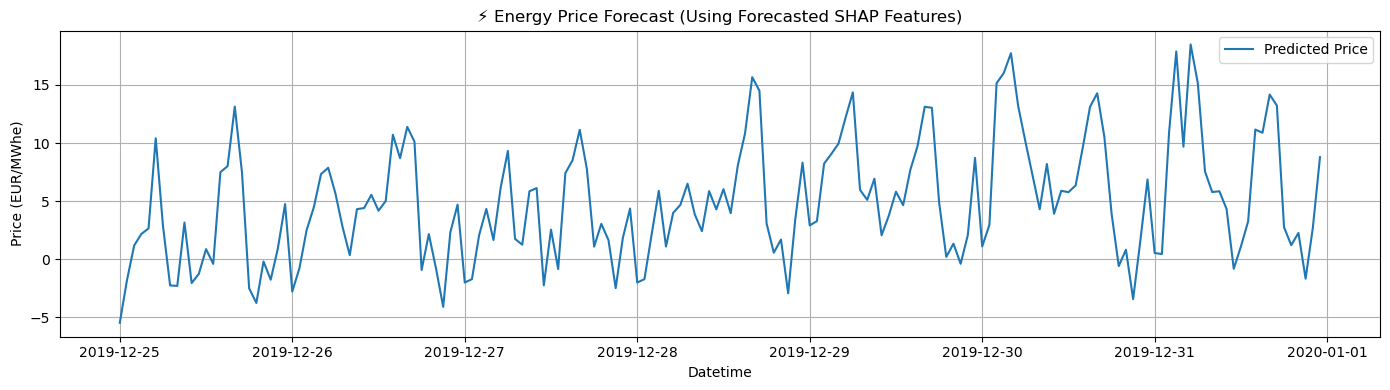

✅ Forecasted energy prices saved.


In [8]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Load forecasted features
df_inputs = pd.read_csv('../data/processed/multioutput_forecast_shap_features_fast.csv', index_col=0, parse_dates=True)

# Recreate any missing features
df_inputs['price_lag_1h'] = np.nan  # Placeholder, no previous price at t=0
df_inputs['price_lag_24h'] = np.nan
df_inputs['price_lag_168h'] = np.nan

# Create calendar features
df_inputs['hour'] = df_inputs.index.hour
df_inputs['dayofweek'] = df_inputs.index.dayofweek
df_inputs['month'] = df_inputs.index.month

# Final feature set (must match what model was trained on)
features = [
    'price_lag_1h', 'price_lag_24h', 'price_lag_168h',
    'hour', 'DE_load_actual_entsoe_transparency',
    'wind_load_ratio', 'solar_load_ratio'
]

# Fill lagged prices with actual values from 2019 (optional — if available)
# Or just set to 0 or reasonable baseline
df_inputs[['price_lag_1h', 'price_lag_24h', 'price_lag_168h']] = 0

# Load or reuse model
model = XGBRegressor(n_estimators=100)
df_all = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])
df_all.set_index('utc_timestamp', inplace=True)
df_all['price_lag_1h'] = df_all['Price (EUR/MWhe)'].shift(1)
df_all['price_lag_24h'] = df_all['Price (EUR/MWhe)'].shift(24)
df_all['price_lag_168h'] = df_all['Price (EUR/MWhe)'].shift(168)
df_all['hour'] = df_all.index.hour
df_all['dayofweek'] = df_all.index.dayofweek
df_all['month'] = df_all.index.month
df_all['solar_load_ratio'] = df_all['DE_solar_generation_actual'] / df_all['DE_load_actual_entsoe_transparency']
df_all['wind_load_ratio'] = df_all['DE_wind_generation_actual'] / df_all['DE_load_actual_entsoe_transparency']

# Train model using original data
df_train = df_all[features + ['Price (EUR/MWhe)']].dropna()
X_train = df_train[features]
y_train = df_train['Price (EUR/MWhe)']
model.fit(X_train, y_train)

# Predict on new inputs
y_pred = model.predict(df_inputs[features])

# Plot
plt.figure(figsize=(14, 4))
plt.plot(df_inputs.index, y_pred, label='Predicted Price')
plt.title("⚡ Energy Price Forecast (Using Forecasted SHAP Features)")
plt.ylabel("Price (EUR/MWhe)")
plt.xlabel("Datetime")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Save if needed
df_price_forecast = pd.DataFrame({'Price (EUR/MWhe)': y_pred}, index=df_inputs.index)
df_price_forecast.to_csv('../data/processed/final_energy_price_forecast_2020_week1.csv')
print("✅ Forecasted energy prices saved.")


📉 Final Evaluation (Dec 25–31, 2019) → MAE: 27.05, RMSE: 28.48


C:\Users\iTECH\AppData\Local\Temp\ipykernel_14288\2893013553.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\iTECH\.julia\conda\3\x86_64\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


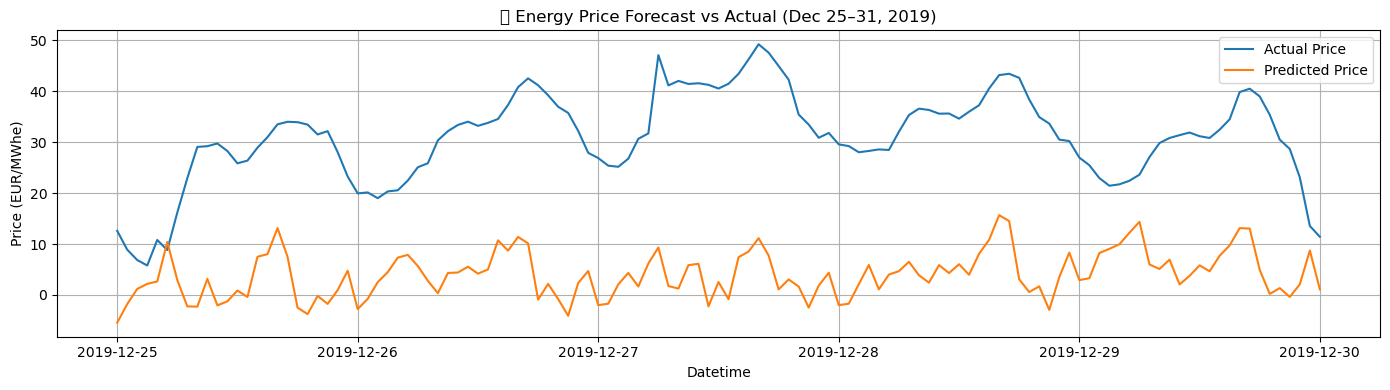

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load actual energy prices
df_actual = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])
df_actual.set_index('utc_timestamp', inplace=True)

# Select actual prices for the forecasted week
actual_prices = df_actual['Price (EUR/MWhe)'].loc['2019-12-25':'2019-12-31']

# Load forecasted prices with datetime as index
df_forecast = pd.read_csv('../data/processed/final_energy_price_forecast_2020_week1.csv', index_col=0, parse_dates=True)
predicted_prices = df_forecast['Price (EUR/MWhe)']

# Align by index
common_index = actual_prices.index.intersection(predicted_prices.index)
actual = actual_prices.loc[common_index]
predicted = predicted_prices.loc[common_index]

# Evaluate
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"📉 Final Evaluation (Dec 25–31, 2019) → MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Plot
plt.figure(figsize=(14, 4))
plt.plot(actual.index, actual, label='Actual Price')
plt.plot(predicted.index, predicted, label='Predicted Price')
plt.title("📊 Energy Price Forecast vs Actual (Dec 25–31, 2019)")
plt.ylabel("Price (EUR/MWhe)")
plt.xlabel("Datetime")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Tried predicting features and then predicting energy prices using these features but the results were bad </br>
Finished by Jad Akra on April 20th 2025